Note: all experiments in this file have the major version 2. So an experiment
listed as '1' will be found in the experiments folder under 
'experiments/2/1/<patch>'. The patch version is free to be used by each 
individual experiment.

In [10]:
%%capture
import tensorflow as tf
import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import efficientnet.efficientnet_builder as efnet_builder
import efficientnet.efficientnet_model as efnet_model
# import util

# tf.logging.set_verbosity(tf.logging.WARN)
tf.logging.set_verbosity(tf.logging.ERROR)
# Set locale for printing (e.g. where to place integer separator ','s).
import locale
locale.setlocale(locale.LC_ALL, '')  # Use '' for auto, or force e.g. to 'en_US.UTF-8'

# Sequential execution, class filter and contribution ranked feature pruning
The hypothesis is that the following three techniques can significantly reduce 
computation requirements of image classification neural networks:
  1. Compute a subset of the global average pool input (subset of 7x7 layer 
     output for EfficientNet). Sequentially compute outputs until classification 
     confidence is achieved.
  2. Determine the stochastic contributions of layer outputs to subsequent layer
     activations. Ignore inputs that don't meet a certain threshold. 
  3. Use a small sized network operating on a scaled down input image to 
     calculate with high accuracy the top 10 classes. This is hoped to reduce
     the need to compute features in the previous layers: compute only 50% of 
     2nd last layer outputs (feature layer), 75% of 3rd last layer, 87.5% of 4th
     last layer. The actual reduction relationship is not known.
     

## 1. Sequential pooling
If there is a reliable pattern of activation of layer 'block 15', the layer with
7x7xfiters outputs connecting to the global pool, this pattern could be used to
determine a subset of the 49 output 'pixels' \[What are the 'pixels' of the 
inner layers called?\] that can be computed with minimal effect on 
classification accuracy. 

More precisely, we could set a minimum required accuracy (in expectation) and
compute only a subset of the 49 pixels if one of the following sets of
functions can be well approximated. Each set needs to address 

### 1.1 Stopping condition
We need a mapping from current activations to expected accuracy degradation. 
Pixels should continue to be calculated until the minimum expected accuracy is
reached. The available state data we have is the 49x1280 neuron outputs and the 
1280 pooled outputs. Possible mappings could be:

  1. g(num_pixels_evaluated | order) = accuracy_estimate
  2. total_pool_output = f(state data). g(total_pool_output) = accuracy_estimate
  3. f(pixels_evaluated) = contribution_estimate. g(contribution) = accuracy_estimate
  
An intermediate quantity that might be a good proxy for estimating accuracy is
the cross-entropy between the normal classification ouput and the perturbed 
classification output.
  
For the above 3 mappings, we would need to measure and parameterize the 
following distributions:

  1. (X, Y): (num pixels evaluated, accuracy | eval order)
  2. (X, Y): (total pool output, accuracy)
  3. (X, Z): (pixel, contribution), (Z, Y): (expected contribution sum, accuracy)
  
These distributions require the following information: 

  1. (correct classification?, num pixels evaluated)
  2. (correct classifciation?, total pool output)
  3. (correct classification?, percentage contribution)
          [49] (pixel, contribution)
  
  

### 1.2 Pixel evaluation order
Which pixels should be calculated next so as to maximize accuracy. Naive orders
could be sequential from top-left to bottom right, or a random order.


### 1.3 Dependency on class activations
With 1280 neurons connected densely to the pool layer, it is not feasible to 
calculate the 1280 class activations each time a pool value is updated. However,
if #3 above is implemented, the smaller number of considered classes would allow
the class activations to be computed multiple times without a significant effect 
on overall operation count. 

## 2 Masked pixels accuracy test. 
Test sequential pooling with accuracy estimate based on the number of pixels 
evaluated.

Success criteria: 

    * discover that dropping random pixels has minimal effect on the accuracy 
      for small drop counts.
    * extra: discover that some specific pixels have minimal effect on accuracy 
      (i.e. classification depends disproportionately on certain pixels).

### 2.1 Experiment-1. Single masked pixel.
Test the classification accuracy when a single pixel is set to zero. Do this 
for all pixels. The number of evaluations per mask test: 64 * 1024.

#### 2.1.1 Results 
(experiment id: 2.1.1)

The results are stored in a Tensorboard event file. Extract the data as follows:

In [11]:
# Extract statistics from tensorboard event file.
import numpy as np
import tensorflow as tf

event_path = 'gs://micronet_bucket1/models/experiments/2/1/1/eval/events.out.tfevents.1566892828.kdoran1'

mask_to_accuracy = [0]*49
values = []
for event in tf.train.summary_iterator(event_path):
    summary = event.summary
    if not summary.ListFields():
        continue
    container = event.summary.value
    for val in container:
        prefix = 'mask_accuracy_'
        if val.tag.startswith('mask_accuracy'):
            pixel_count = int(val.tag[len(prefix):])
            # mask_to_accuracy[pixel_count] = val.simple_value
            mask_to_accuracy[pixel_count] = val.simple_value

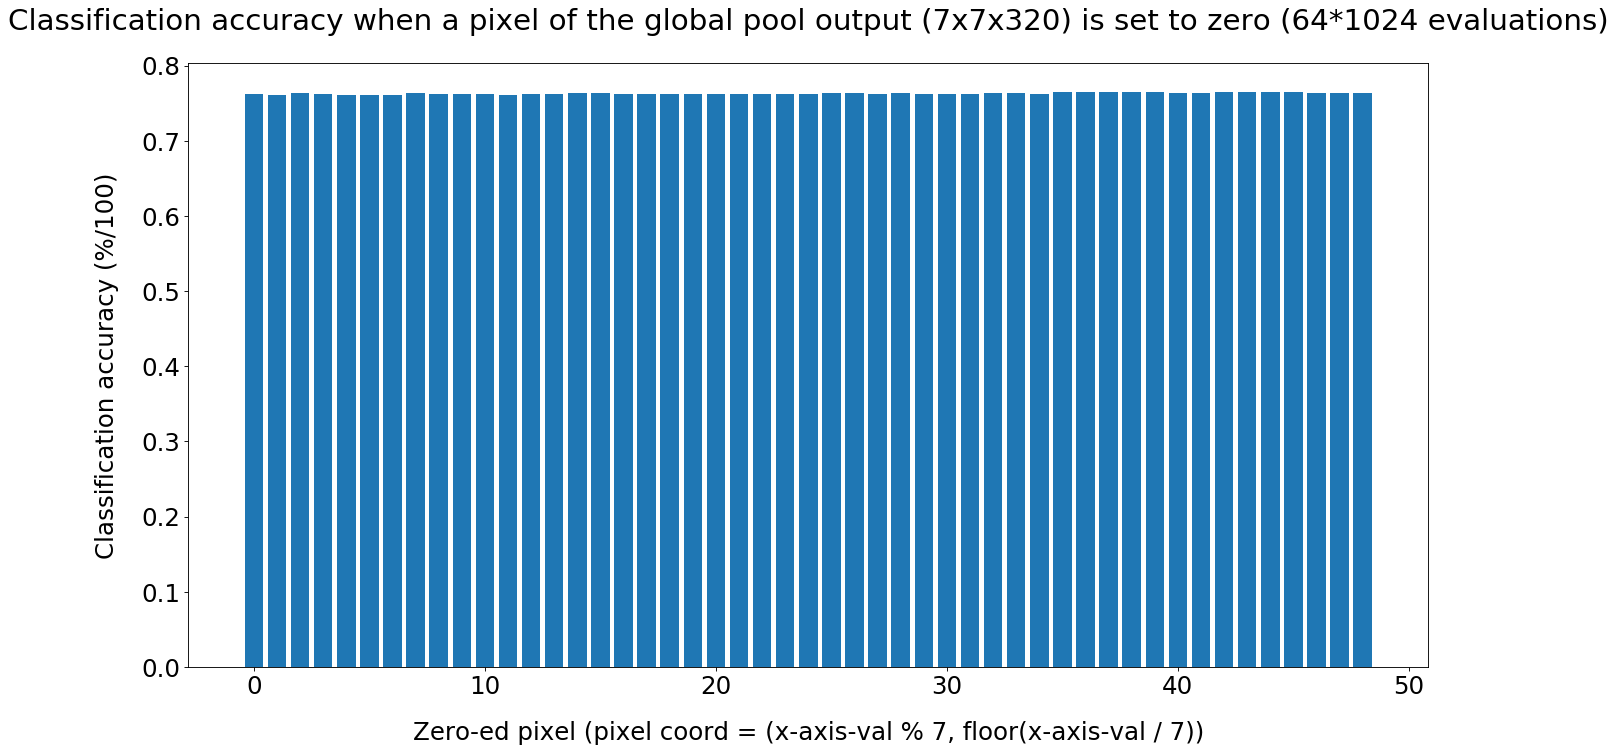

original accuracy: 0.75146484
max masked accuracy: 0.7651367
min masked accuracy: 0.76049805


In [17]:
# num evaluations: 64 * 1024
# Hard-coded results in-case the event file gets lost. 
res = {'accuracy': 0.75146484, 'mask_accuracy_18': 0.7624512, 'mask_accuracy_40': 0.76342773, 'mask_accuracy_26': 0.7631836, 'mask_accuracy_35': 0.7651367, 'mask_accuracy_29': 0.7624512, 'mask_accuracy_43': 0.76416016, 'mask_accuracy_27': 0.7626953, 'mask_accuracy_10': 0.76220703, 'mask_accuracy_16': 0.7619629, 'mask_accuracy_11': 0.76123047, 'mask_accuracy_46': 0.7636719, 'mask_accuracy_48': 0.76342773,  'mask_accuracy_2': 0.7631836, 'mask_accuracy_31': 0.7619629, 'mask_accuracy_37': 0.7644043, 'mask_accuracy_36': 0.76464844, 'mask_accuracy_23': 0.76171875, 'mask_accuracy_47': 0.76293945, 'mask_accuracy_45': 0.7644043, 'mask_accuracy_34': 0.7626953, 'mask_accuracy_38': 0.76464844, 'mask_accuracy_0': 0.7626953, 'mask_accuracy_30': 0.76220703, 'mask_accuracy_20': 0.7626953, 'mask_accuracy_1': 0.7609863, 'mask_accuracy_22': 0.7624512, 'mask_accuracy_39': 0.7644043, 'mask_accuracy_24': 0.7624512, 'mask_accuracy_8': 0.7626953, 'mask_accuracy_6': 0.7607422, 'mask_accuracy_7': 0.76342773, 'mask_accuracy_13': 0.7624512, 'mask_accuracy_19': 0.76171875, 'mask_accuracy_25': 0.76293945, 'mask_accuracy_9': 0.7619629, 'mask_accuracy_14': 0.7631836, 'mask_accuracy_28': 0.76293945, 'mask_accuracy_44': 0.76464844, 'mask_accuracy_17': 0.7619629, 'mask_accuracy_33': 0.7631836, 'mask_accuracy_15': 0.76293945, 'mask_accuracy_5': 0.76049805, 'mask_accuracy_42': 0.76464844, 'mask_accuracy_32': 0.7636719, 'mask_accuracy_3': 0.7624512, 'mask_accuracy_4': 0.76123047, 'mask_accuracy_21': 0.76171875, 'mask_accuracy_41': 0.763916, 'mask_accuracy_12': 0.76171875}
masked_accuracies = tuple(res['mask_accuracy_' + str(a)] for a in range(49))
plt.figure(figsize=(20,10), dpi=80)
matplotlib.rcParams.update({'font.size': 22})
plt.bar(range(49), masked_accuracies)
plt.title('Classification accuracy when a pixel of the global pool output '
          '(7x7x320) is set to zero (64*1024 evaluations)', pad=30)
plt.xlabel('Zero-ed pixel (pixel coord = (x-axis-val % 7, floor(x-axis-val / 7))', labelpad=20)
plt.ylabel('Classification accuracy (%/100)', labelpad=20)
plt.show()
print(f'original accuracy: {res["accuracy"]}')
print(f'max masked accuracy: {max(masked_accuracies)}')
print(f'min masked accuracy: {min(masked_accuracies)}')

#### 2.1.2 Conclusion
Zero-ing a single pixel in the 7x7 grid of features consistently produces higher 
accuracy.

This is a strange result, one that raises the question: was the
experiment flawed?

If the results are reliable, then it shows that there is no single pixel that is
vital.

### 2.2 Experiment-2. 25, 40, 48, & 49 masked pixels.
Run with 10 * 64 * 1024 samples with different number of randomly placed masks.
Each experiment fixes a certain number of pixels to be set to zero. The pixels
are placed randomly for _each_ classification example. This experiment tests
the following number of pixel masks (with gloud storage experiment ids in 
brackets):

  * 25 (2.2.1)
  * 40 (2.2.2)
  * 48 (2.2.3)
  * 49 (2.2.4)

#### 2.2.1 Results
The accuracies for each of the mask counts are:

  * 25: 0.754
  * 40: 0.690
  * 48: 0.890
  * 49: 0.00104
  
The control (49 masks) reduces to 0.1% (1/1000), which is reasonable. This is 
some evidence that the experiment setup is not flawed. 

### 2.3 Experiment-3. All mask counts
Extending experiment 2.2 to check all mask counts (0-48).
Git hash: f2534c7e4c71.
Experiment id: 2.3
Each of the 50 evaluations [0, 49] have their own patch experiment version.
Each evaluation ran for `20 * 64 * 2**10 = 1,310,720` samples.

#### 2.3.1 Results

In [19]:
# Hard-coded results. Also obtainable from Tensorboard event files.
res = {
    0:  {'accuracy': 0.7722748,  'loss': 6.373776,  'global_step': 0}, 
    1:  {'accuracy': 0.7713448,  'loss': 6.3870153, 'global_step': 0}, 
    2:  {'accuracy': 0.77148056, 'loss': 6.400982,  'global_step': 0}, 
    3:  {'accuracy': 0.7708542,  'loss': 6.4113493, 'global_step': 0}, 
    4:  {'accuracy': 0.7701584,  'loss': 6.4265227, 'global_step': 0}, 
    5:  {'accuracy': 0.77015686, 'loss': 6.4401665, 'global_step': 0}, 
    6:  {'accuracy': 0.7696327,  'loss': 6.459356,  'global_step': 0}, 
    7:  {'accuracy': 0.7693329,  'loss': 6.477136,  'global_step': 0}, 
    8:  {'accuracy': 0.76907957, 'loss': 6.4935455, 'global_step': 0}, 
    9:  {'accuracy': 0.76794434, 'loss': 6.5143137, 'global_step': 0}, 
    10: {'accuracy': 0.7672447,  'loss': 6.5355697, 'global_step': 0}, 
    11: {'accuracy': 0.7668396,  'loss': 6.5554,    'global_step': 0}, 
    12: {'accuracy': 0.76668775, 'loss': 6.577124,  'global_step': 0}, 
    13: {'accuracy': 0.7658783,  'loss': 6.598773,  'global_step': 0}, 
    14: {'accuracy': 0.7654678,  'loss': 6.620036,  'global_step': 0}, 
    15: {'accuracy': 0.7645996,  'loss': 6.645002,  'global_step': 0}, 
    16: {'accuracy': 0.76330644, 'loss': 6.663367,  'global_step': 0}, 
    17: {'accuracy': 0.7627632,  'loss': 6.685964,  'global_step': 0}, 
    18: {'accuracy': 0.762088,   'loss': 6.706272,  'global_step': 0}, 
    19: {'accuracy': 0.7613937,  'loss': 6.726879,  'global_step': 0}, 
    20: {'accuracy': 0.76027524, 'loss': 6.74701,   'global_step': 0}, 
    21: {'accuracy': 0.7586586,  'loss': 6.7663393, 'global_step': 0}, 
    22: {'accuracy': 0.75752103, 'loss': 6.7821207, 'global_step': 0}, 
    23: {'accuracy': 0.756488,   'loss': 6.797246,  'global_step': 0}, 
    24: {'accuracy': 0.75536805, 'loss': 6.811171,  'global_step': 0}, 
    25: {'accuracy': 0.7540207,  'loss': 6.8246336, 'global_step': 0}, 
    26: {'accuracy': 0.7521011,  'loss': 6.8362885, 'global_step': 0}, 
    27: {'accuracy': 0.75086594, 'loss': 6.847026,  'global_step': 0}, 
    28: {'accuracy': 0.7484924,  'loss': 6.856795,  'global_step': 0}, 
    29: {'accuracy': 0.74651796, 'loss': 6.864248,  'global_step': 0}, 
    30: {'accuracy': 0.74389344, 'loss': 6.8712287, 'global_step': 0}, 
    31: {'accuracy': 0.74184114, 'loss': 6.877139,  'global_step': 0}, 
    32: {'accuracy': 0.738356,   'loss': 6.882619,  'global_step': 0}, 
    33: {'accuracy': 0.73541105, 'loss': 6.886907,  'global_step': 0}, 
    34: {'accuracy': 0.73149186, 'loss': 6.890538,  'global_step': 0}, 
    35: {'accuracy': 0.7276436,  'loss': 6.893767,  'global_step': 0}, 
    36: {'accuracy': 0.7230133,  'loss': 6.896392,  'global_step': 0}, 
    37: {'accuracy': 0.7161499,  'loss': 6.89845,   'global_step': 0}, 
    38: {'accuracy': 0.70957106, 'loss': 6.900379,  'global_step': 0}, 
    39: {'accuracy': 0.70189893, 'loss': 6.901845,  'global_step': 0}, 
    40: {'accuracy': 0.69045943, 'loss': 6.903028,  'global_step': 0}, 
    41: {'accuracy': 0.6781967,  'loss': 6.9041443, 'global_step': 0}, 
    42: {'accuracy': 0.6611885,  'loss': 6.9049516, 'global_step': 0}, 
    43: {'accuracy': 0.63974303, 'loss': 6.9056497, 'global_step': 0}, 
    44: {'accuracy': 0.60791856, 'loss': 6.906184,  'global_step': 0}, 
    45: {'accuracy': 0.56284255, 'loss': 6.906636,  'global_step': 0}, 
    46: {'accuracy': 0.4922096,  'loss': 6.907028,  'global_step': 0}, 
    47: {'accuracy': 0.3753357,  'loss': 6.9072733, 'global_step': 0}, 
    48: {'accuracy': 0.18807144, 'loss': 6.9075866, 'global_step': 0},
    49: {'accuracy': 0.00101471, 'loss': 6.907757,  'global_step': 0}}

mask_count_to_accuracy = [0] * 50 
for i in range(len(mask_count_to_accuracy)):
    mask_count_to_accuracy[i] = res[i]['accuracy']

Text(0, 0.5, 'Classification accuracy (%/100)')

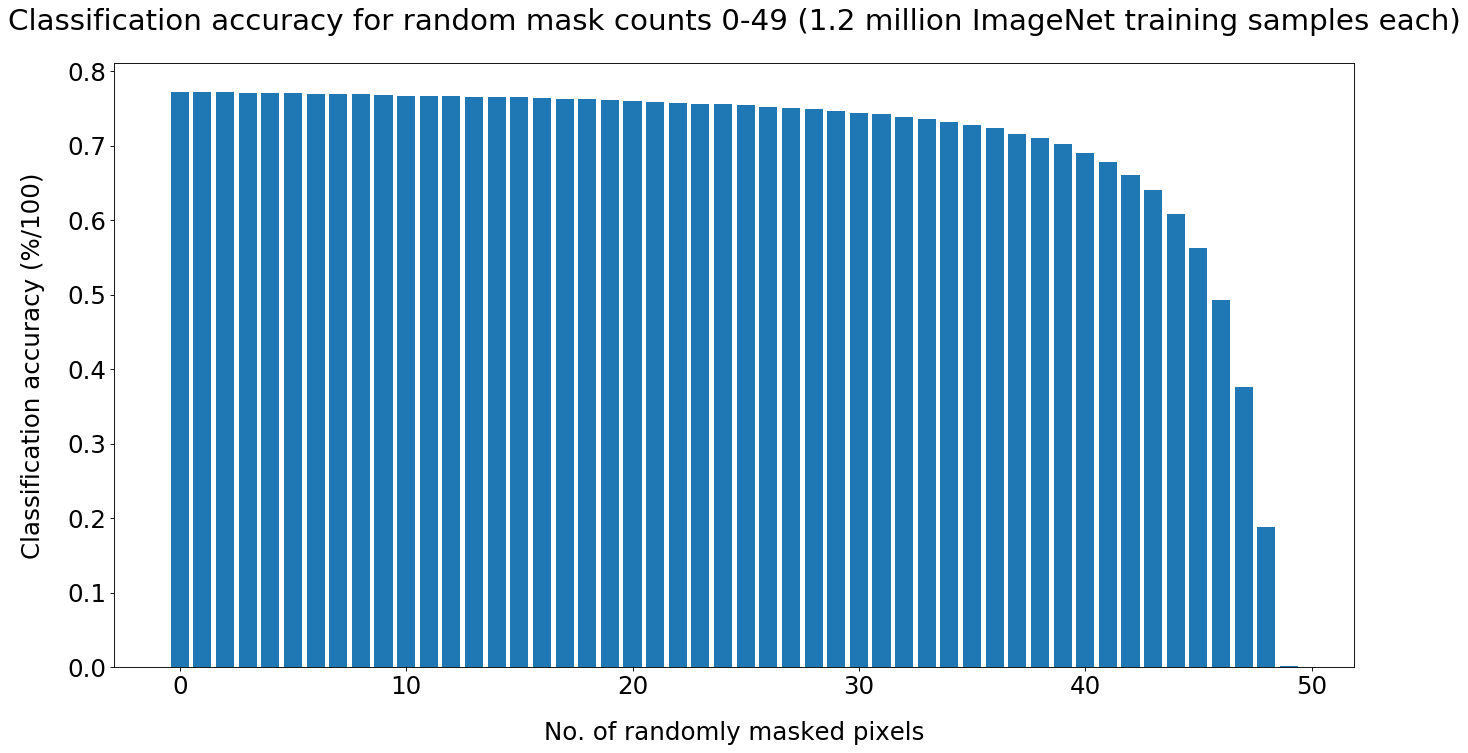

In [24]:
x_axis = np.arange(len(mask_count_to_accuracy))
plt.figure(figsize=(20,10), dpi=80)
matplotlib.rcParams.update({'font.size': 22})
plt.bar(x_axis, mask_count_to_accuracy)
plt.title('Classification accuracy for random mask counts 0-49 (1.2 million ImageNet training samples each)', pad=30)
plt.xlabel('No. of randomly masked pixels', labelpad=20)
plt.ylabel('Classification accuracy (%/100)', labelpad=20)

#### 2.3.2 Conclusion
This is rather amazing. There is 19% accuracy when using only a single pixel!

Calculating a single pixel could be used to rule out some classes!

### Reinforcement learning approach to evaluation order and stopping.
This experiment aims to investigate the effectiveness of using a reinforcement 
learning (RL) algorithm to determine the evaluation order. 

With a well defined state space and reward function, a benefit of using an RL
approach is that the value function can be designed to represent expected 
classification accuracy. Thus, a by product of determining the evaluation order
is a statistic that can be used in a stopping condition. This addresses both
of the requirements outlined above in section 1.